In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [2]:
# Generar datos sintéticos de una serie de tiempo
data = np.sin(np.linspace(0, 100, 1000))  # Serie univariable
sequence_length = 50

# Crear secuencias de entrada (X) y etiquetas (Y)
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

X, Y = create_sequences(data, sequence_length)
X_train, Y_train = X[:800], Y[:800]
X_test, Y_test = X[800:], Y[800:]

# Convertir a tensores
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

In [3]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, seq_length, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model, 
            nhead=nhead, 
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout
        )
        self.fc_out = nn.Linear(d_model, 1)  # Salida univariable

    def forward(self, src):
        # Embedding y codificación posicional
        src = self.input_embedding(src) + self.positional_encoding
        # Transformer
        output = self.transformer(src, src)
        # Proyección a salida
        return self.fc_out(output[:, -1, :])

In [4]:
input_dim = 1  # Cambiar a >1 para series multivariables
d_model = 64
nhead = 4
num_layers = 2
seq_length = sequence_length

model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, seq_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/gmartinez/Deep-Learning-exercises/.venv/lib64/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
num_epochs = 20
batch_size = 32

train_loader = DataLoader(
    dataset=torch.utils.data.TensorDataset(X_train, Y_train), 
    batch_size=batch_size, 
    shuffle=True
)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(-1))  # Añadir dimensión para univariable
        loss = criterion(outputs.squeeze(), Y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/20, Loss: 0.6874
Epoch 2/20, Loss: 0.0449
Epoch 3/20, Loss: 0.0271
Epoch 4/20, Loss: 0.0187
Epoch 5/20, Loss: 0.0176
Epoch 6/20, Loss: 0.0158
Epoch 7/20, Loss: 0.0141
Epoch 8/20, Loss: 0.0136
Epoch 9/20, Loss: 0.0129
Epoch 10/20, Loss: 0.0169
Epoch 11/20, Loss: 0.0108
Epoch 12/20, Loss: 0.0106
Epoch 13/20, Loss: 0.0127
Epoch 14/20, Loss: 0.0104
Epoch 15/20, Loss: 0.0105
Epoch 16/20, Loss: 0.0156
Epoch 17/20, Loss: 0.0115
Epoch 18/20, Loss: 0.0098
Epoch 19/20, Loss: 0.0105
Epoch 20/20, Loss: 0.0103


Test Loss: 0.0072


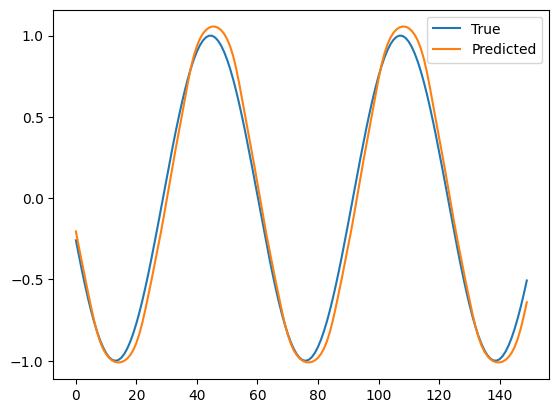

In [6]:
model.eval()
with torch.no_grad():
    predictions = model(X_test.unsqueeze(-1)).squeeze()
    test_loss = criterion(predictions, Y_test)
    print(f"Test Loss: {test_loss.item():.4f}")

# Visualización
plt.plot(Y_test.numpy(), label="True")
plt.plot(predictions.numpy(), label="Predicted")
plt.legend()
plt.show()